In [59]:
import glob
import os
import torch
import numpy as np
import xarray as xr
import netCDF4 as nc
import pandas as pd
import simpy as sp
import logging
import multiprocessing as mp
from multiprocessing import Pool

In [2]:
import cdsapi

In [3]:
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [4]:
os.chdir('..')

In [5]:
%load_ext autoreload
%autoreload 2

In [ ]:
from datasets.retieval import retieve_era5, grab_df_from_era5_csvs
from datasets.utils import unzip_csv_or_nc_batch

In [7]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# ERA5 Data Retrieval for Koopman Forecast of Maritime Weather

## ERA5 Around Hamburg Harbor

ERA5 is a dataset which provides hourly maritime weather data.<br>
Its API does only provide single point measurements, but we can play a little and grab this data for multiple points all together.

![Map with coordinated of HH harbor with midpoint of the grid.](../img/map_grid_hhh.png)<br>
*Coastal map. The blue point is at coordinates lon 10 and lat 53.5, around Hamburg Harbor.*<br>
*The red dot is representing the initial radius taken when data mining the region of interest.*<br>
*One can see that that the mean on that point needs to be far more at the caostal line to get sufficiant forecasting!*

In [84]:
# params
dataset = "reanalysis-era5-single-levels-timeseries"
center_lon, center_lat = 5.5, 56.5
radius = 4.5
step = 0.5
start_date = '2025-02-01'
end_date = '2025-09-30'
output_dir = f"./data/{start_date}--{end_date}"
os.makedirs(output_dir, exist_ok=True)

import glob

for fp1 in glob.glob('./data/*/*.nc'):
    fp1 = os.path.abspath(fp1)
    fp1 = fp1.replace('\\', '/')
    fp0 = '/'.join(fp1.split('/')[:-1])
    fn1 = fp1.replace(fp0, '')
    fn2 = fn1.replace('.nc', '_compr.zip')
    fp2 = fp0 + fn2
    os.rename(fp1, fp2)
    

In [9]:
lon_vals = np.arange(center_lon - radius, center_lon + radius + step, step)
lat_vals = np.arange(center_lat - radius, center_lat + radius + step, step)

# Create list of (lon, lat) pairs
tasks = [(lon, lat) for lon in lon_vals for lat in lat_vals]

In [ ]:
if not os.path.exists(output_dir):
    retieve_era5(dataset, (center_lon, center_lat), radius, step, start_date, end_date, [
        "2m_dewpoint_temperature",
        "mean_sea_level_pressure",
        "skin_temperature",
        "surface_pressure",
        "surface_solar_radiation_downwards",
        "sea_surface_temperature",
        "surface_thermal_radiation_downwards",
        "2m_temperature",
        "total_precipitation",
        "10m_u_component_of_wind",
        "10m_v_component_of_wind",
        "100m_u_component_of_wind",
        "100m_v_component_of_wind",
        "mean_wave_direction",
        "mean_wave_period",
        "significant_height_of_combined_wind_waves_and_swell"
    ])

In [ ]:
raw_df = grab_df_from_era5_csvs(output_dir, lat_vals, lon_vals)
raw_df.shape

(2096688, 19)

In [69]:
df = raw_df.groupby(['time', 'lat', 'lon']).agg(np.nanmean).reset_index(drop=False)

C:\Users\szaif\AppData\Local\Temp\ipykernel_19892\1590245969.py:1: FutureWarning: The provided callable <function nanmean at 0x000001CB67E40220> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df = raw_df.groupby(['time', 'lat', 'lon']).agg(np.nanmean).reset_index(drop=False)


In [70]:
df

,time,lat,lon,u100,v100,u10,v10,d2m,t2m,msl,sst,skt,sp,ssrd,strd,tp,mwd,mwp,swh
0,2025-02-01 00:00:00,52.0,1.0,-1.227249,4.551605,-0.971558,2.206314,276.52350,277.55730,103012.19,NaN,275.89688,102521.016,0.0,987721.6,0.000000,NaN,NaN,NaN
1,2025-02-01 00:00:00,52.0,1.5,-1.064163,5.324066,-0.894409,3.730728,276.45320,278.51044,103029.19,NaN,278.12344,102849.016,0.0,948745.6,0.000000,172.52643,4.089964,0.726625
2,2025-02-01 00:00:00,52.0,2.0,-1.182327,6.403168,-1.083862,5.754166,276.31450,279.34050,103046.94,281.59595,280.98672,103040.016,0.0,926793.6,0.000000,185.69049,4.595823,0.778139
3,2025-02-01 00:00:00,52.0,2.5,-1.313187,6.841644,-1.243042,6.271744,275.97858,279.32490,103074.69,281.68970,281.14297,103078.016,0.0,919625.6,0.000000,228.72955,5.153929,0.901918
4,2025-02-01 00:00:00,52.0,3.0,-1.309280,6.379730,-1.294800,5.887955,276.23444,279.09247,103109.69,281.09497,280.77774,103112.016,0.0,926057.6,0.000000,278.97955,5.439573,0.874330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096683,2025-09-30 23:00:00,61.0,8.0,-1.131500,2.283813,-0.720962,1.216782,275.14008,276.67023,103289.31,NaN,275.09850,88800.266,0.0,1125228.5,0.000031,NaN,NaN,NaN
2096684,2025-09-30 23:00:00,61.0,8.5,-0.486969,2.181274,-0.548111,1.381821,275.57172,276.38702,103361.06,NaN,275.39930,89915.266,0.0,1136748.5,0.000076,NaN,NaN,NaN
2096685,2025-09-30 23:00:00,61.0,9.0,-0.358063,2.487915,-0.445572,1.501938,276.41937,277.25616,103397.31,NaN,276.58875,92960.266,0.0,1139756.5,0.000033,NaN,NaN,NaN
2096686,2025-09-30 23:00:00,61.0,9.5,-0.533844,2.779907,-0.502212,1.663071,275.91547,276.54718,103433.81,NaN,276.26648,93282.266,0.0,1136748.5,0.000018,NaN,NaN,NaN


In [71]:
vars = list(set(df.columns).difference(['time', 'lat', 'lon']))
df[~df['u10'].isna()].shape

(2096688, 19)

In [72]:
df_sum = df.groupby(['lon', 'lat'])[vars].agg(np.nanmean).reset_index(drop=False)
df_sum['miss'] = df_sum.agg(lambda x: x.isna().any(), axis=1)

C:\Users\szaif\AppData\Local\Temp\ipykernel_19892\2816070113.py:1: FutureWarning: The provided callable <function nanmean at 0x000001CB67E40220> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_sum = df.groupby(['lon', 'lat'])[vars].agg(np.nanmean).reset_index(drop=False)


In [73]:
df_sum.shape

(361, 19)

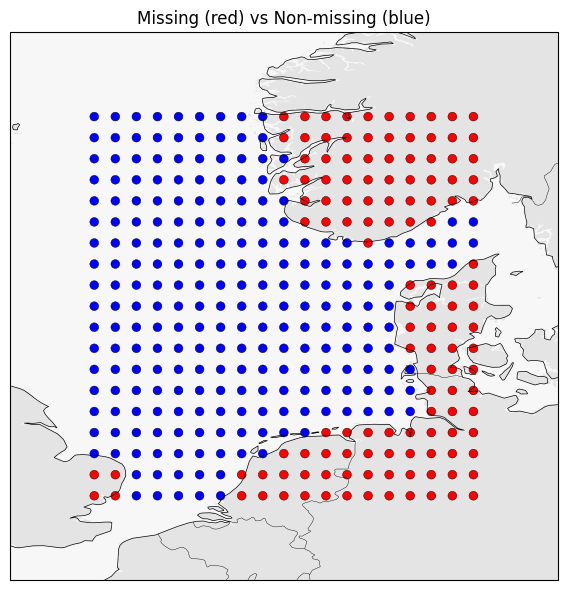

In [75]:
fig, ax = plt.subplots(figsize=(7, 6), subplot_kw={"projection": ccrs.PlateCarree()})

# Add fine coastlines and borders
ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth=0.5)
ax.add_feature(cfeature.BORDERS.with_scale("50m"), linewidth=0.3)
ax.add_feature(cfeature.LAND, facecolor="lightgray", alpha=0.6)
ax.add_feature(cfeature.OCEAN, facecolor="whitesmoke", alpha=0.7)

# Compute zoom area with margin
margin = 2
ax.set_extent([
    df_sum["lon"].min() - margin,
    df_sum["lon"].max() + margin,
    df_sum["lat"].min() - margin,
    df_sum["lat"].max() + margin
], crs=ccrs.PlateCarree())

# Plot points (red = missing, blue = present)
colors = df_sum["miss"].map({True: "red", False: "blue"})
ax.scatter(df_sum["lon"], y=df_sum["lat"], c=colors, s=40, edgecolor="black", linewidth=0.3, transform=ccrs.PlateCarree())

plt.title("Missing (red) vs Non-missing (blue)", fontsize=12)
plt.tight_layout()
plt.show()

In [76]:
df =  df.merge(df_sum[['lat', 'lon', 'miss']], on=['lat', 'lon'], how='left')
df_all = df.copy()

In [77]:
df = df[~df['miss']]

In [78]:
df['tp_zero'] = df['tp'] == 0

In [79]:
# Convert time column to datetime if not already
df['time'] = pd.to_datetime(df['time'])
df['hour'] = df['time'].dt.hour
df['date'] = df['time'].dt.date
df = df.drop('time', axis=1)

In [80]:
df

,lat,lon,u100,v100,u10,v10,d2m,t2m,msl,sst,...,ssrd,strd,tp,mwd,mwp,swh,miss,tp_zero,hour,date
2,52.0,2.0,-1.182327,6.403168,-1.083862,5.754166,276.31450,279.34050,103046.94,281.59595,...,0.0,926793.60,0.0,185.69049,4.595823,0.778139,False,True,0,2025-02-01
3,52.0,2.5,-1.313187,6.841644,-1.243042,6.271744,275.97858,279.32490,103074.69,281.68970,...,0.0,919625.60,0.0,228.72955,5.153929,0.901918,False,True,0,2025-02-01
4,52.0,3.0,-1.309280,6.379730,-1.294800,5.887955,276.23444,279.09247,103109.69,281.09497,...,0.0,926057.60,0.0,278.97955,5.439573,0.874330,False,True,0,2025-02-01
5,52.0,3.5,-1.298538,5.904144,-1.464722,5.008072,276.45320,278.36786,103147.19,279.98267,...,0.0,929801.60,0.0,308.49518,5.769896,0.783510,False,True,0,2025-02-01
6,52.0,4.0,-0.907913,5.661957,-1.045776,3.383072,275.20320,275.96942,103178.69,279.00317,...,0.0,920073.60,0.0,306.04987,5.658079,0.550844,False,True,0,2025-02-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096673,61.0,3.0,-4.056305,16.806274,-3.350845,13.281235,281.94867,286.12335,102681.56,285.94800,...,0.0,1206508.50,0.0,170.92366,6.642595,3.018293,False,True,23,2025-09-30
2096674,61.0,3.5,-3.455719,16.899048,-2.919205,13.669907,281.49164,286.16240,102763.06,286.35913,...,0.0,1152044.50,0.0,175.37679,6.575213,2.971662,False,True,23,2025-09-30
2096675,61.0,4.0,-2.604157,16.504517,-2.247330,13.646469,280.99164,286.32062,102839.06,287.30835,...,0.0,1095500.50,0.0,180.35335,6.412615,2.763655,False,True,23,2025-09-30
2096676,61.0,4.5,-1.921539,14.758423,-1.735611,12.393539,280.51117,286.39484,102910.31,287.67358,...,0.0,1050028.50,0.0,186.72054,6.042986,2.270491,False,True,23,2025-09-30


In [ ]:
# Save to parquet
df.to_parquet(
    f"D:/data/cfd/era5/{start_date}--{end_date}__hourly_era5_data.parquet", 
    partition_cols=['date', 'hour', 'lat', 'lon', 'tp_zero'],
    compression='gzip',
    engine='fastparquet'
)

: 

## HAVOC